In [1]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids


In [3]:
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Gender', 'Converted-MMSE']].to_dict(orient='index')


In [4]:
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

# Load labels
label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)


In [5]:
combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels:
        label_data = labels[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Age': label_data['Age'],
            'Gender': label_data['Gender'],
            'Converted-MMSE': label_data['Converted-MMSE'],
            'Class': label_data['Class']
        })

# Create a DataFrame from combined data
df = pd.DataFrame(combined_data)

# Encode categorical variables
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})  # Map Gender
df['Class'] = df['Class'].astype('category').cat.codes     # Map Class to numeric codes

# Drop rows with missing values in important columns
df.dropna(subset=['Text', 'Class', 'Age', 'Gender', 'Converted-MMSE'], inplace=True)


In [6]:
X = df[['Text', 'Age', 'Gender', 'Class']]
y = df['Converted-MMSE']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Text'),             # Text features using TF-IDF
        ('numeric', MinMaxScaler(), ['Age', 'Gender', 'Class'])  # Scale numeric features
    ]
)

# Define regression model
model = GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=5, min_samples_split=10)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text', TfidfVectorizer(),
                                                  'Text'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['Age', 'Gender',
                                                   'Class'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=10,
                                           random_state=42))])

In [8]:
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Squared Error: 2.56
R^2 Score: 0.39


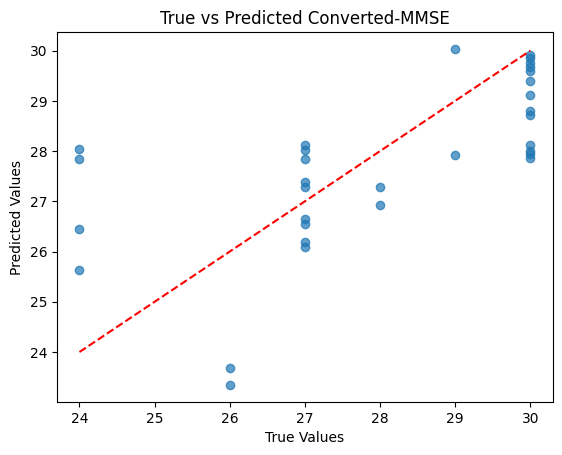

ValueError: array length 32 does not match index length 47

In [9]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Converted-MMSE")
plt.show()

# Save predictions
predictions_df = pd.DataFrame({
    'Record-ID': df.iloc[X_test.index]['Record-ID'],
    'Text': X_test['Text'],
    'Age': X_test['Age'],
    'Gender': X_test['Gender'],
    'Class': X_test['Class'],
    'True Converted-MMSE': y_test,
    'Predicted Converted-MMSE': y_pred
})

predictions_df.to_csv("predictions_with_features_regression.csv", index=False)
print("Predictions saved to 'predictions_with_features_regression.csv'.")
